In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

In [129]:
device = torch.device('cpu')

device

device(type='cpu')

In [130]:
torch.backends.mps.is_available()

True

In [282]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
valid_data = pd.read_csv('valid.csv')
data = test_data
data = pd.concat([train_data, test_data, valid_data], join='inner')


In [285]:
data

,questions,answers
0,Can you imagine the world without internet acc...,"Yeah, but once the access to the internet was ..."
1,Can you imagine the world without internet acc...,"Well, I know that more people started using it..."
2,Can you imagine the world without internet acc...,Yeah. And the Internet actually developed from...
3,Can you imagine the world without internet acc...,"Well, I know that it is defined as the ability..."
4,I am just finishing my university course and I...,I am a bot so that is not posible. Do you perf...
...,...,...
3412,"Hi, I'm looking to buy a Harley bike. Have you...","I do, it was founded in Milwaukee, Wisconsin"
3413,My sister is a baker. She bakes mostly cakes a...,A baker is someone who bakes.
3414,My sister is a baker. She bakes mostly cakes a...,It has to do with breads and other products ma...
3415,My sister is a baker. She bakes mostly cakes a...,That's great! Baking has been around as long a...


In [286]:
NUM_NEGATIVE_RES = 2
SEQ_LENGTH = 100
BATCH_SIZE = 60
HIDDEN_SIZE = 128

In [287]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.3 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [288]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from traitlets.traitlets import default
import spacy
from collections import defaultdict



[nltk_data] Downloading package punkt to /Users/yasas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yasas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [289]:
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")


dic = defaultdict(set)


for itr in range(0, len(data['answers'])-40, 20):
  sentence = ' '.join(data['answers'][itr:itr+20])
  doc = nlp(sentence)

  # Print out each entity found in the sentence along with its label
  for ent in doc.ents:
    dic[ent.label_].add(ent.text)
for ent in dic:
  print(ent, dic[ent])

DATE {'the 70s', 'up to three weeks', "the Seven Years'", '1839', '1912', '70', '60s', 'late 1800s', 'less than 2 days', 'the Middle Ages', 'the sixth and fifth centuries', 'more than 3 millennia', 'early 20th century', '1990', 'the year of 2000', '1717', 'age 15', '45 years old', 'the early 1600s', '1911', 'under 5 year old', 'up to multiple days', "the early 1920's", 'June of 2009', '55 million years ago', 'the new millennium', '1967', 'the 17th century', 'January 26, 2011', 'the 20th century', '1965 to 1968', "the fourth century's end", '1937 to 2011', '67,000 years ago', 'the 20th of October', 'fourteen years', 'five decades', 'his second year', '18', 'six month', 'early 20th centuries', 'the later half of the 1500s', 'the next year', 'July 29, 1993', '1983', '1950s', '10 years', 'the past 50 years', 'September 13, 2009', '1978', '1895', 'December 2012', 'at least a year', 'the late 1700s', 'between 1989 and 2005', 'the year 1990', '1816', '1849-50', 'October 1, 1958', 'Winter', '7

In [290]:
import random
# Example sentence
def generateNegRes(row):
  for itr in range(NUM_NEGATIVE_RES):
    text = row['answers']

    doc = nlp(text)

    # Loop through named entities in the sentence
    for ent in doc.ents:
      if ent.label_ in dic:
        # Replace named entity with a random entity from the corresponding list in the dictionary
        new_entity = random.choice(list(dic[ent.label_]))
        text = text.replace(ent.text, new_entity)
    row['neg_ans' + str(itr)] = text
  return row

data = data.apply(lambda row: generateNegRes(row), axis=1)
data

,questions,answers,neg_ans0,neg_ans1
0,Can you imagine the world without internet acc...,"Yeah, but once the access to the internet was ...","Yeah, but once the access to the internet was ...","Yeah, but once the access to the internet was ..."
1,Can you imagine the world without internet acc...,"Well, I know that more people started using it...","Well, I know that more people started using it...","Well, I know that more people started using it..."
2,Can you imagine the world without internet acc...,Yeah. And the Internet actually developed from...,Yeah. And the Internet actually developed from...,Yeah. And the Internet actually developed from...
3,Can you imagine the world without internet acc...,"Well, I know that it is defined as the ability...","Well, I know that it is defined as the ability...","Well, I know that it is defined as the ability..."
4,I am just finishing my university course and I...,I am a bot so that is not posible. Do you perf...,I am a bot so that is not posible. Do you perf...,I am a bot so that is not posible. Do you perf...
...,...,...,...,...
3412,"Hi, I'm looking to buy a Harley bike. Have you...","I do, it was founded in Milwaukee, Wisconsin","I do, it was founded in Dayona Beach, Newfound...","I do, it was founded in Manassas, New Mexico"
3413,My sister is a baker. She bakes mostly cakes a...,A baker is someone who bakes.,A baker is someone who bakes.,A baker is someone who bakes.
3414,My sister is a baker. She bakes mostly cakes a...,It has to do with breads and other products ma...,It has to do with breads and other products ma...,It has to do with breads and other products ma...
3415,My sister is a baker. She bakes mostly cakes a...,That's great! Baking has been around as long a...,That's great! Baking has been around as long a...,That's great! Baking has been around as long a...


In [291]:
def stripSentences(row):
  punct = set({'!', '.', '?', ','})
  for sen in row.keys():
    row[sen] = row[sen].strip().split(" ")
    sent = row[sen]
    for i in range(len(sent)):
      if len(sent[i])>0:
        if sent[i][-1] in punct:
          sent[i] = sent[i][:-1]
    row[sen] = sent
  return row

data_stripped = data.apply(lambda row: stripSentences(row), axis=1)
data_stripped

,questions,answers,neg_ans0,neg_ans1
0,"[Can, you, imagine, the, world, without, inter...","[Yeah, but, once, the, access, to, the, intern...","[Yeah, but, once, the, access, to, the, intern...","[Yeah, but, once, the, access, to, the, intern..."
1,"[Can, you, imagine, the, world, without, inter...","[Well, I, know, that, more, people, started, u...","[Well, I, know, that, more, people, started, u...","[Well, I, know, that, more, people, started, u..."
2,"[Can, you, imagine, the, world, without, inter...","[Yeah, And, the, Internet, actually, developed...","[Yeah, And, the, Internet, actually, developed...","[Yeah, And, the, Internet, actually, developed..."
3,"[Can, you, imagine, the, world, without, inter...","[Well, I, know, that, it, is, defined, as, the...","[Well, I, know, that, it, is, defined, as, the...","[Well, I, know, that, it, is, defined, as, the..."
4,"[I, am, just, finishing, my, university, cours...","[I, am, a, bot, so, that, is, not, posible, Do...","[I, am, a, bot, so, that, is, not, posible, Do...","[I, am, a, bot, so, that, is, not, posible, Do..."
...,...,...,...,...
3412,"[Hi, I'm, looking, to, buy, a, Harley, bike, H...","[I, do, it, was, founded, in, Milwaukee, Wisco...","[I, do, it, was, founded, in, Dayona, Beach, N...","[I, do, it, was, founded, in, Manassas, New, M..."
3413,"[My, sister, is, a, baker, She, bakes, mostly,...","[A, baker, is, someone, who, bakes]","[A, baker, is, someone, who, bakes]","[A, baker, is, someone, who, bakes]"
3414,"[My, sister, is, a, baker, She, bakes, mostly,...","[It, has, to, do, with, breads, and, other, pr...","[It, has, to, do, with, breads, and, other, pr...","[It, has, to, do, with, breads, and, other, pr..."
3415,"[My, sister, is, a, baker, She, bakes, mostly,...","[That's, great, Baking, has, been, around, as,...","[That's, great, Baking, has, been, around, as,...","[That's, great, Baking, has, been, around, as,..."


In [292]:
temp = data_stripped
index2word = defaultdict(list)
for key in temp.keys():
  index2word[key] = ["<PAD>", "<SOS>", "<EOS>"]
  for ds in temp[key]:
    for token in ds:
      if token not in index2word[key]:
        index2word[key].append(token)
print(index2word)

defaultdict(<class 'list'>, {'questions': ['<PAD>', '<SOS>', '<EOS>', 'Can', 'you', 'imagine', 'the', 'world', 'without', 'internet', 'access', 'Yeah', 'but', 'once', 'to', 'was', 'a', 'rare', 'thing', 'do', 'remember', 'I', 'What', 'else', 'can', 'tell', 'me', '', 'Well', 'know', 'that', 'more', 'people', 'started', 'using', 'it', 'after', 'some', 'restrictions', 'on', 'use', 'were', 'lifited', 'in', '1995', 'That', 'is', 'awesome', 'wonder', 'why', 'restricted', 'Probably', 'because', 'they', 'only', 'wanted', 'government', 'and', 'big', 'companies', 'at', 'first', 'And', 'Internet', 'actually', 'developed', 'from', 'project', 'founded', 'by', 'called', 'ARPANET', 'responsible', 'for', 'suppoting', 'projects', 'universities', 'within', 'Very', 'Interesting', 'about', 'Access', 'am', 'just', 'finishing', 'my', 'university', 'course', 'will', 'be', 'qualified', 'pharmacist', 'so', 'excited', 'getting', 'out', 'there', 'into', 'of', 'work', 'Do', 'yourself', 'bot', 'not', 'posible', 'pe

In [293]:
for key in temp.keys():
    print(key, len(index2word[key]))

questions 30205
answers 26386
neg_ans0 26299
neg_ans1 26333


In [294]:
word2index = defaultdict(dict)
for key in temp.keys():
  word2index[key] = {token: idx for idx, token in enumerate(index2word[key])}

In [295]:
index2word['questions'][20]

'remember'

In [296]:
word2index['questions']['chain']

1090

In [297]:
def encode_and_pad(vocab, sent, max_length):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]

    if len(sent) < max_length - 2:
        n_pads = max_length - 2 - len(sent)
        encoded = [vocab[w] for w in sent]
        return sos + encoded + eos + pad * n_pads 
    else:
        encoded = [vocab[w] for w in sent]
        truncated = encoded[:max_length - 2]
        return sos + truncated + eos

In [298]:
encoded = defaultdict(list)
for key in temp.keys():
  encoded[key] = [encode_and_pad(word2index[key], sent, SEQ_LENGTH) for sent in temp[key]]

In [299]:
nparrays = defaultdict(np.array)
for key in temp.keys():
  nparrays[key] = np.array(encoded[key])

In [300]:
torchtens = defaultdict(torch.from_numpy)
for key in temp.keys():
  torchtens[key] = torch.from_numpy(nparrays[key])

In [301]:
temp_tuples = [torchtens[key] for key in torchtens]
ds = TensorDataset(*temp_tuples)
dl = DataLoader(ds, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [302]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0)
        
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded

        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, BATCH_SIZE, self.hidden_size)

In [303]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        
        self.gru = nn.GRU(hidden_size, hidden_size)

        self.out = nn.Linear(hidden_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input)

        output = F.relu(output)

        output, hidden = self.gru(output, hidden)

        output = self.softmax(self.out(output[0]))
        
        return output, hidden

In [304]:
encoder = EncoderRNN(len(index2word['questions']), HIDDEN_SIZE).to(device)
decoder = DecoderRNN(HIDDEN_SIZE, len(index2word['answers'])).to(device)

In [305]:
encoder

EncoderRNN(
  (embedding): Embedding(30205, 128, padding_idx=0)
  (gru): GRU(128, 128, batch_first=True)
)

In [306]:
decoder

DecoderRNN(
  (embedding): Embedding(26386, 128, padding_idx=0)
  (gru): GRU(128, 128)
  (out): Linear(in_features=128, out_features=26386, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [307]:
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 3e-3)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 3e-3)

In [308]:
losses = []


In [309]:
def LNCE(zx, zy, negative_samples, tau=1):
  zy_one_hot = torch.zeros_like(zx)
  zy_one_hot.scatter_(1, zy.unsqueeze(1), 1)
  numerator = torch.exp(torch.cosine_similarity(zx, zy_one_hot) / tau)
  denominators = []
  neg_one_hot = {}
  for sample in negative_samples:
    temp = torch.zeros_like(zx)
    temp.scatter_(1, sample.unsqueeze(1), 1)
    neg_one_hot[sample] = temp
  for itr in neg_one_hot:
    denominators.append(torch.sum(torch.exp(torch.cosine_similarity(zx, neg_one_hot[itr]) / tau)))
  ln_ce = -torch.log(numerator / sum(denominators)+numerator)
  return ln_ce.mean()+1


In [310]:
input_length = target_length = SEQ_LENGTH

SOS = word2index['questions']["<SOS>"]
EOS = word2index['questions']["<EOS>"]

epochs = 15

for epoch in range(epochs):
  for idx, batch in enumerate(dl):

    encoder_hidden = encoder.initHidden()

    encoder_hidden = encoder_hidden.to(device)

    input_tensor = batch[0].to(device)

    target_tensor = batch[1].to(device)

    negative_embeddings = []
    for i in range(NUM_NEGATIVE_RES):
      x = batch[i+2].to(device)
      negative_embeddings.append(x)
    

    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()

    with torch.set_grad_enabled(True):
        
      encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

      dec_result = torch.zeros(target_length, BATCH_SIZE, len(index2word['answers'])).to(device)

      decoder_input = target_tensor[:, 0].unsqueeze(dim=0).to(device)

      decoder_hidden = encoder_hidden

      for i in range(1, target_length):
          
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        
        best = decoder_output.argmax(1)

        decoder_input = best.unsqueeze(dim=0) 

        dec_result[i] = decoder_output

      scores = dec_result.transpose(1, 0)[1:].reshape(-1, dec_result.shape[2])
      targets = target_tensor[1:].reshape(-1)
      neg_embeddings = []
      for itr in range(NUM_NEGATIVE_RES):
        x = negative_embeddings[itr]
        neg_embeddings.append(x[1:].reshape(-1))
      torch.autograd.set_detect_anomaly(True)
      loss = LNCE(scores, targets, neg_embeddings)
      
      loss.backward()
      
      torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
      torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

      enc_optimizer.step()
      dec_optimizer.step()

      losses.append(loss.item())
      print(epoch, idx, sum(losses)/len(losses))

0 0 1.0055055618286133
0 1 1.0054408311843872
0 2 1.0054351488749187
0 3 1.005421370267868
0 4 1.0054030418395996
0 5 1.0053784251213074
0 6 1.0053453275135584
0 7 1.0052960366010666
0 8 1.005202054977417
0 9 1.0050428628921508
0 10 1.0048510052941062
0 11 1.004656821489334
0 12 1.0044584916188166
0 13 1.0042655297688075
0 14 1.0040574232737223
0 15 1.00387704372406
0 16 1.0036965678719914
0 17 1.0035285751024883
0 18 1.003365391179135
0 19 1.0032202184200287
0 20 1.003080271539234
0 21 1.0029604760083286
0 22 1.0028455361076023
0 23 1.0027369409799576
0 24 1.0026347923278809
0 25 1.0025392495668852
0 26 1.002453119666488
0 27 1.0023718178272247
0 28 1.0023012736748005
0 29 1.0022341847419738
0 30 1.002168390058702
0 31 1.0021076276898384
0 32 1.0020508152065855
0 33 1.0019970045370215
0 34 1.0019458225795201
0 35 1.001893983946906
0 36 1.001849129393294
0 37 1.0018053086180436
0 38 1.0017631176190498
0 39 1.0017239034175873
0 40 1.0016846511422135
0 41 1.0016461270196098
0 42 1.001609

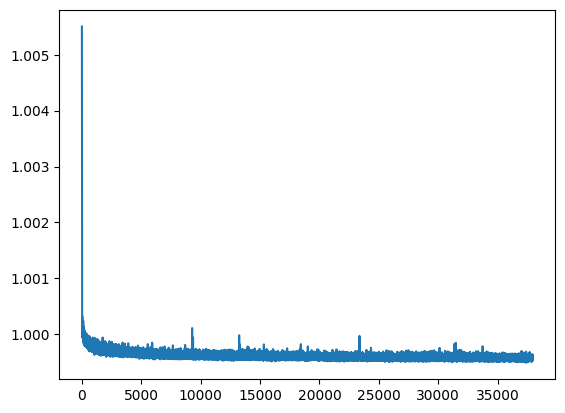

In [315]:
plt.plot(losses)


In [316]:
test_sentence = "I love candy, what's a good brand?	"

def stripSentences(row):
  punct = set({'!', '.', '?', ','})
  for sen in row.keys():
    row[sen] = row[sen].strip().split(" ")
    sent = row[sen]
    for i in range(len(sent)):
      if len(sent[i])>0:
        if sent[i][-1] in punct:
          sent[i] = sent[i][:-1]
    row[sen] = sent
  return row

row = {'sent':test_sentence}
test_sentence = stripSentences(row)['sent']
test_sentence = ' '.join(test_sentence)

test_sentence = torch.tensor(encode_and_pad(word2index['questions'], test_sentence.split(), SEQ_LENGTH)).unsqueeze(dim=0)

In [317]:
encoder_hidden = torch.zeros(1, 1, HIDDEN_SIZE)
encoder_hidden = encoder_hidden.to(device)

input_tensor = test_sentence.to(device)

enc_optimizer.zero_grad()
dec_optimizer.zero_grad()

result = []

encoder_outputs = torch.zeros(SEQ_LENGTH, encoder.hidden_size, device=device)


with torch.set_grad_enabled(False):
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

    dec_result = torch.zeros(target_length, 1, len(index2word['answers'])).to(device)

    decoder_input = torch.tensor([SOS]).unsqueeze(dim=0).to(device)
    decoder_hidden = encoder_hidden
    for di in range(1, target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        best = decoder_output.argmax(1)
        result.append(index2word['answers'][best.to('cpu').item()])
        if best.item() == EOS:
            break

        decoder_input = best.unsqueeze(dim=0) 
        dec_result[di] = decoder_output

    scores = dec_result.reshape(-1, dec_result.shape[2])
    targets = target_tensor.reshape(-1)

In [318]:
" ".join(result)


'I I not you that that that the the <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [319]:
torch.save(encoder.state_dict(), './contrastive_encoder')
torch.save(decoder.state_dict(), './contrastive_decoder')

In [320]:
index2word

defaultdict(list,
            {'questions': ['<PAD>',
              '<SOS>',
              '<EOS>',
              'Can',
              'you',
              'imagine',
              'the',
              'world',
              'without',
              'internet',
              'access',
              'Yeah',
              'but',
              'once',
              'to',
              'was',
              'a',
              'rare',
              'thing',
              'do',
              'remember',
              'I',
              'What',
              'else',
              'can',
              'tell',
              'me',
              '',
              'Well',
              'know',
              'that',
              'more',
              'people',
              'started',
              'using',
              'it',
              'after',
              'some',
              'restrictions',
              'on',
              'use',
              'were',
              'lifited',
           

In [321]:
model_encoder = EncoderRNN(len(index2word['questions']), HIDDEN_SIZE).to(device)
model_encoder.load_state_dict(torch.load('./contrastive_encoder'))
model_encoder.eval()

EncoderRNN(
  (embedding): Embedding(30205, 128, padding_idx=0)
  (gru): GRU(128, 128, batch_first=True)
)

In [323]:
model_decoder = DecoderRNN(HIDDEN_SIZE, len(index2word['answers'])).to(device)
model_decoder.load_state_dict(torch.load('./contrastive_decoder'))
model_decoder.eval()

DecoderRNN(
  (embedding): Embedding(26386, 128, padding_idx=0)
  (gru): GRU(128, 128)
  (out): Linear(in_features=128, out_features=26386, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [324]:
encoder_hidden = torch.zeros(1, 1, HIDDEN_SIZE)
encoder_hidden = encoder_hidden.to(device)

input_tensor = test_sentence.to(device)

enc_optimizer.zero_grad()
dec_optimizer.zero_grad()

result = []

encoder_outputs = torch.zeros(SEQ_LENGTH, model_encoder.hidden_size, device=device)


with torch.set_grad_enabled(False):
    encoder_output, encoder_hidden = model_encoder(input_tensor, encoder_hidden)

    dec_result = torch.zeros(target_length, 1, len(index2word['answers'])).to(device)

    decoder_input = torch.tensor([SOS]).unsqueeze(dim=0).to(device)
    decoder_hidden = encoder_hidden
    for di in range(1, target_length):
        decoder_output, decoder_hidden = model_decoder(decoder_input, decoder_hidden)
        best = decoder_output.argmax(1)
        result.append(index2word['answers'][best.to('cpu').item()])
        if best.item() == EOS:
            break

        decoder_input = best.unsqueeze(dim=0) 
        dec_result[di] = decoder_output

    scores = dec_result.reshape(-1, dec_result.shape[2])
    targets = target_tensor.reshape(-1)

In [325]:
" ".join(result)

'I I not you that that that the the <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [326]:
indices = [{'ans_w2i': word2index['answers'], 'ques_i2w': index2word['questions'], 'ans_i2w': index2word['answers'], 'ques_w2i': word2index['questions']}]

In [327]:
import json
f = open('./contrastive_indices.json', 'w')
json.dump(indices, f, indent=6)